In [205]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from IPython.display import display, clear_output 
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import time
import csv
%matplotlib inline

### Import and Format Data

In [206]:
# import training.csv which contains a header row of face locations and 'image,' the column of lists of pixel values
with open("training.csv") as f:
    train_import = list(csv.reader(f))

# shuffle the data    
removed_header = train_import[1:]
shuffle = np.random.permutation(np.arange(len(removed_header)))
shuffled_train_import = [removed_header[i] for i in shuffle]
    
# divide the rows 80% for training and 20% for development    
train_portion = int(.8*(len(shuffled_train_import)))
dev_portion = len(shuffled_train_import) - train_portion

# extract training and development data
train_data = shuffled_train_import[:train_portion]
dev_data = shuffled_train_import[-dev_portion:]

# initialize the list of lists of pixel values 
train_image_data = []

# convert each list of pixel values (1 per row) to integers (first split the string up then convert each elem to int)
for row in range(len(train_data)):
    train_image_data.append([int(i) for i in list(train_data[row][30].split())])
# convert to a numpy array
train_image_data = np.array(train_image_data)

# convert range of 0 to 255 for pixel values to 0 to 1 (0 = white, 1 = black)
train_image_data = train_image_data/255.0
    
# initialize array of the 30 different facial location target values (labels) for each example image
train_image_labels = np.empty((len(train_data), 30))

# iterate through each row and each example image's 30 target facial locations and covert to floats or NaNs
for i in range(len(train_data)):
    for j in range(len(train_data[i][0:30])):
        if train_data[i][j] == '':
            train_image_labels[i][j] = float('nan')
        else: 
            train_image_labels[i][j] = (float(train_data[i][j]))

#### Remove Rows with NaN Target Values

In [207]:
# remove rows where 'left_eye_center_x' == NaN values from the training and label data
non_NaN_list = np.invert((np.isnan(train_image_labels[:,0])))
cln_train_image_data = train_image_data[non_NaN_list]
cln_train_image_labels = train_image_labels[non_NaN_list]




### Linear Regression - Facial Recognition

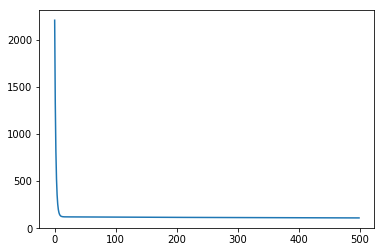

In [208]:
tf.reset_default_graph()
trainX = tf.constant(cln_train_image_data, dtype = tf.float32)
# only attempting 1 out of 30 facial locations (column 0), 'left_eye_center_x'
trainY = tf.constant(cln_train_image_labels[:,0], dtype = tf.float32)
learningRate = tf.constant(0.0001)
# create beta variable (vector of 9216 beta values: 1 for each pixel)
beta = tf.get_variable('beta', initializer=np.zeros((9216,1), dtype = np.float32))

def model(this_beta, x):
    return tf.matmul(x, this_beta)

def cost(this_beta):
    ans = tf.reduce_mean((model(this_beta, trainX) - trainY)**2) / 2
    return ans

cc = cost(beta)

## Gradient descent by tensorflow
gd = tf.train.GradientDescentOptimizer(learningRate)
step = gd.minimize(cost(beta))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    cost_vec = []
    # By running step multiple times, we perform gradient descent for the variable beta. 
    # For each step, we can ouput the cost function.
    for i in range(500):
        _, cost = sess.run([step, cc])
        cost_vec.append(cost)
        my_beta = sess.run([beta])[0]
    plt.plot(cost_vec)


### Test the Betas with the Development Data

In [209]:
'''REPEATING SAME TREATMENT OF DATA THAT WAS DONE TO THE TRAINING PORTION'''
# initialize the development list of lists of pixel values 
dev_image_data = []

# convert each list of pixel values (1 per row) to integers (first split the string up then convert each elem to int)
for row in range(len(dev_data)):
    dev_image_data.append([int(i) for i in list(dev_data[row][30].split())])
# convert to a numpy array
dev_image_data = np.array(dev_image_data)

# convert range of 0 to 255 for pixel values to 0 to 1 (0 = white, 1 = black)
dev_image_data = dev_image_data/255.0

# initialize array of the 30 different facial location target values (labels) for each example image
dev_image_labels = np.empty((len(dev_data), 30))

# iterate through each row and each example image's 30 target facial locations and covert to floats or NaNs
for i in range(len(dev_data)):
    for j in range(len(dev_data[i][0:30])):
        if dev_data[i][j] == '':
            dev_image_labels[i][j] = float('nan')
        else: 
            dev_image_labels[i][j] = (float(dev_data[i][j]))

#### Remove Rows with NaN Target Values

In [210]:
# remove rows where 'left_eye_center_x' == NaN values from the dev and dev_label data
non_NaN_list = np.invert((np.isnan(dev_image_labels[:,0])))
cln_dev_image_data = dev_image_data[non_NaN_list]
cln_dev_image_labels = dev_image_labels[non_NaN_list]

### Calculate RMSE from Development Data

In [211]:
# determine predicted x-coordiate for 'left_eye_center_x', named y_hat to match RMSE formula in Kaggle competition
y_hat = np.matmul(cln_dev_image_data, my_beta)

# y represents the original coordinate for left_eye_center_x'
y = cln_dev_image_labels[:,0]

n = len(y)

# root mean squared error
rmse = np.sqrt(np.sum((y[0] - y_hat)**2)/float(n))

print(rmse)

14.8318886191
